# Load Data

In [ ]:
import numpy as np
import os
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import sklearn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Load train and test data**

In [ ]:
# Load the train.csv file into a DataFrame name train_data_set
train_data_set = pd.read_csv('train.csv')

# Load the test.csv file into a DataFrame name test_data_set
test_data_set = pd.read_csv('test.csv')

**Load pre-trained Word2Vec feature vectores**

In [ ]:
# Load the pre-trained Word2Vec vectors
word2vec_model_path = 'word2vec.model-skipgram-size=200-window=5.bin'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

# Accessing the vector for a specific word
vector_for_word = word_vectors['خوب']

# Dimensionality of the vectors
vector_dimensionality = word_vectors.vector_size

print(f"Vector for 'خوب': {vector_for_word}")
print(f"Dimensionality of vectors: {vector_dimensionality}")

Vector for 'خوب': [ 0.05189532 -0.04367696 -0.25825545 -0.31841868 -0.3135765  -0.20935565
 -0.07008067  0.03917047 -0.03930867  0.24164495 -0.02684353 -0.14871739
  0.32636547  0.04250283 -0.20503595  0.31462032 -0.35309905 -0.1457835
  0.19296333 -0.0202606  -0.26901004  0.09482329 -0.26851743 -0.2677326
  0.41082373 -0.46436322  0.05367912  0.20031756 -0.14810108 -0.46825427
 -0.13223809  0.35961193  0.1269391   0.2910871  -0.26136425 -0.23105039
 -0.1675703  -0.06026964 -0.13725972 -0.10071518  0.16619743 -0.54662055
 -0.0567041  -0.08579624 -0.08841149  0.41507357  0.12886804  0.07238836
 -0.02152005  0.14836814  0.26444688 -0.08293931 -0.3177732  -0.12926306
  0.29344997  0.00163315 -0.13231517  0.34714785 -0.2602429   0.37017608
  0.00499069  0.19122368 -0.14609908 -0.26162016  0.07910927 -0.16766837
  0.21102104  0.5089599  -0.28373197 -0.12223705 -0.22153029  0.09425112
  0.20062323 -0.24341087  0.10108037 -0.08430991  0.34745726  0.01433752
  0.31164107  0.19027296  0.2332513

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# &mdash; Pre-process the Data

* a) Tokenize sentences into the words (for both train and test)
* b) Craete a list of **Average** Word2Vec vectors for each tokenized comment based on individual words Word2Vec feature (for both train and test)
* c) Craete a list of **Sum** Word2Vec vectors for each tokenized comment based on individual words Word2Vec feature (for both train and test)

**a) Tokenize sentences into the words**

Train

In [ ]:
# Tokenize sentences into words (train)
from nltk.tokenize import word_tokenize

# Tokenize the sentences and create a list of lists containing tokenized words (train)
tokenized_words_train = []

for comment in train_data_set['comment']:
    tokens = word_tokenize(comment)
    tokenized_words_train.append(tokens)
print(tokenized_words_train[:5])

print(len(tokenized_words_train))

[['واقعا', 'حیف', 'وقت', 'که', 'بنویسم', 'سرویس', 'دهیتون', 'شده', 'افتضاح'], ['قرار', 'بود', '۱', 'ساعته', 'برسه', 'ولی', 'نیم', 'ساعت', 'زودتر', 'از', 'موقع', 'رسید،', 'شما', 'ببین', 'چقدرررررررررررر', 'پلاک', 'خفنههههه،', 'من', 'سالهاست', 'مشتریشونم', 'و', 'سالهاست', 'مزه', 'بهشت', 'میده', 'غذاشون'], ['قیمت', 'این', 'مدل', 'اصلا', 'با', 'کیفیتش', 'سازگاری', 'نداره،', 'فقط', 'ظاهر', 'فریبنده', 'داره،', 'پرش', 'میکنن', 'کالباس', 'و', 'قارچ'], ['عالللی', 'بود', 'همه', 'چه', 'درست', 'و', 'به', 'اندازه', 'و', 'کیفیت', 'خوب،', 'امیداورم', 'همیشه', 'کیفیتتون', 'خوب', 'باشه', 'ما', 'مشتری', 'همیشگی', 'بشیم'], ['شیرینی', 'وانیلی', 'فقط', 'یک', 'مدل', 'بود', '.']]
63700


Test

In [ ]:
# Tokenize sentences into words (test)
from nltk.tokenize import word_tokenize

# Tokenize the sentences and create a list of lists containing tokenized words (test)
tokenized_words_test = []

for comment in test_data_set['comment']:
    tokens = word_tokenize(comment)
    tokenized_words_test.append(tokens)
print(tokenized_words_test[:5])

print(len(tokenized_words_test))

[['غذا', 'به', 'موقع', 'رسید', 'و', 'برخورد', 'پیک', 'خوب', 'بود'], ['نون', 'فکر', 'کنم', 'مال', 'چهار', 'روز', 'قبل', 'بود', 'کلا', 'نمیشد', 'خورد', 'کراکف', 'رو', 'هم', 'گریل', 'رو', 'بهش', 'نشون', 'داده', 'بودن', 'اصلا', 'از', 'رستوران', 'انتظارم', 'چیز', 'دیگه\u200cای', 'بود', 'دفعه', 'اولم', 'نبود', 'از', 'این', 'رستوران', 'غذا', 'سفارش', 'دادم', 'اما', 'این', 'بار', 'میتونم', 'بگم', 'افتضاح', 'بود'], ['درب', 'قهوه', 'شکسته', 'بود'], ['قهوه', 'نی', 'نداشت', '.', 'یکی', 'از', 'سفارش\u200cها', 'عوض', 'شده', 'بود', '.', 'بقیه', 'خوب', 'بود', '.'], ['خیلی', 'پر', 'پنیر', 'بود', 'و', 'اصلا', 'اصلا', 'تند', 'نبود', 'متاسفانه']]
6259


**b) Craete a list of Average Word2Vec vectors for each tokenized comment based on individual words Word2Vec feature**

Train

In [ ]:
# Create a list of average vectors for each comment (train)
average_Word2Vec_vectors_train = []

for comment in tokenized_words_train:
    vectors = [word_vectors[word] if word in word_vectors else np.zeros(word_vectors.vector_size) for word in comment]

    if not vectors:
        # If there are no valid vectors for a comment, add a zero vector in the same dimension
        average_Word2Vec_vectors_train.append(np.zeros(word_vectors.vector_size))
    else:
        average_vector = np.mean(vectors, axis=0)
        average_Word2Vec_vectors_train.append(average_vector)

# Convert the list of average vectors to a numpy array
average_Word2Vec_train = np.array(average_Word2Vec_vectors_train)

print(average_Word2Vec_train.shape)
print(average_Word2Vec_train[0])

(63700, 200)
[-1.65902043e-01 -1.26873209e-02 -2.96080019e-01 -2.12186100e-01
 -2.49442192e-01 -2.33756869e-01 -4.61200575e-02 -8.35592418e-02
  1.37646625e-01  1.05215343e-01 -1.00566015e-01  1.23241777e-01
  1.46320162e-01  6.96878110e-02  1.07242301e-01  1.25713644e-01
 -2.29505020e-01 -1.64583554e-01  7.21378876e-02  1.41702304e-01
 -2.81875532e-01 -9.90292637e-02 -3.27304299e-01 -2.54362699e-01
 -9.47158771e-02 -1.82666814e-01 -1.40975971e-01  1.00780730e-01
  1.85450161e-01 -3.32910501e-01 -4.56842697e-05 -1.21760683e-02
 -2.04644068e-01  7.70469507e-03 -1.11131930e-01 -1.85472321e-01
 -1.90221765e-01 -1.26736901e-01 -1.16240329e-01  1.17586733e-01
 -3.06366839e-02 -1.07842002e-01  5.28155172e-02 -3.82638209e-02
  6.17364471e-02 -7.64516010e-02  6.82522070e-02  1.03191109e-01
  2.22737209e-01  1.57690234e-01 -5.71463530e-02  2.26348820e-02
  7.35417581e-02 -5.17498106e-02 -6.25447594e-02  2.13883993e-01
 -1.11448517e-01  1.00348345e-01 -1.03302845e-01 -5.45925106e-02
  1.24729192

Test

In [ ]:
# Create a list of average vectors for each comment (test)
average_Word2Vec_vectors_test = []

for comment in tokenized_words_test:
    vectors = [word_vectors[word] if word in word_vectors else np.zeros(word_vectors.vector_size) for word in comment]

    if not vectors:
        # If there are no valid vectors for a comment, add a zero vector in the same dimension
        average_Word2Vec_vectors_test.append(np.zeros(word_vectors.vector_size))
    else:
        average_vector = np.mean(vectors, axis=0)
        average_Word2Vec_vectors_test.append(average_vector)

# Convert the list of average vectors to a numpy array
average_Word2Vec_test = np.array(average_Word2Vec_vectors_test)

print(average_Word2Vec_test.shape)
print(average_Word2Vec_test[0])

(6259, 200)
[-0.16689613  0.04516371 -0.22380288 -0.19798619 -0.03160186 -0.41179827
 -0.04262786 -0.09739291  0.0896561   0.09631862 -0.0684322  -0.12756629
  0.10014889  0.16491425 -0.01976217  0.18269703 -0.20268147 -0.02341793
  0.11927141  0.05432297 -0.11008422  0.02747248 -0.26350781 -0.16330065
  0.09129738 -0.20706293 -0.09945617  0.17509069 -0.08456969 -0.16520625
  0.02366329 -0.00422374 -0.12220355  0.06839868 -0.13428944 -0.02490332
 -0.20837222 -0.03494718 -0.06333517 -0.04095747 -0.06135518 -0.14899874
  0.0769539  -0.01213884 -0.00544674 -0.00633887 -0.00293275 -0.01226751
  0.08521441  0.29204097  0.13839154 -0.07877603  0.03408152 -0.06625363
 -0.07277645 -0.05449048 -0.04284267  0.14033964 -0.01980972  0.02904999
  0.11871953 -0.02867105  0.06211169 -0.153965    0.19169015  0.09378769
  0.12933537  0.15548688 -0.04120565 -0.07595028  0.02028867  0.05708559
 -0.07016621 -0.15668614 -0.1347456  -0.15748677  0.16517897  0.02915587
  0.21629652  0.02661463  0.15556274  0

**c) Craete a list of Sum Word2Vec vectors for each tokenized comment based on individual words Word2Vec feature**

Train

In [ ]:
# Create a list of sum vectors for each comment (train)
sum_Word2Vec_vectors_train = []

for comment in tokenized_words_train:
    vectors = [word_vectors[word] if word in word_vectors else np.zeros(word_vectors.vector_size) for word in comment]

    if not vectors:
        # If there are no valid vectors for a comment, add a zero vector in the same dimension
        sum_Word2Vec_vectors_train.append(np.zeros(word_vectors.vector_size))
    else:
        sum_vector = np.sum(vectors, axis=0)
        sum_Word2Vec_vectors_train.append(sum_vector)

# Convert the list of sum vectors to a numpy array
sum_Word2Vec_train = np.array(sum_Word2Vec_vectors_train)
print(sum_Word2Vec_train.shape)
print(sum_Word2Vec_train[0])

(63700, 200)
[-1.49311839e+00 -1.14185888e-01 -2.66472017e+00 -1.90967490e+00
 -2.24497973e+00 -2.10381182e+00 -4.15080518e-01 -7.52033176e-01
  1.23881962e+00  9.46938083e-01 -9.05094136e-01  1.10917600e+00
  1.31688146e+00  6.27190299e-01  9.65180710e-01  1.13142280e+00
 -2.06554518e+00 -1.48125198e+00  6.49240988e-01  1.27532074e+00
 -2.53687979e+00 -8.91263373e-01 -2.94573869e+00 -2.28926429e+00
 -8.52442894e-01 -1.64400133e+00 -1.26878374e+00  9.07026574e-01
  1.66905145e+00 -2.99619451e+00 -4.11158428e-04 -1.09584615e-01
 -1.84179661e+00  6.93422556e-02 -1.00018737e+00 -1.66925089e+00
 -1.71199589e+00 -1.14063211e+00 -1.04616296e+00  1.05828059e+00
 -2.75730155e-01 -9.70578022e-01  4.75339655e-01 -3.44374388e-01
  5.55628024e-01 -6.88064409e-01  6.14269863e-01  9.28719979e-01
  2.00463488e+00  1.41921211e+00 -5.14317177e-01  2.03713938e-01
  6.61875823e-01 -4.65748295e-01 -5.62902834e-01  1.92495593e+00
 -1.00303665e+00  9.03135106e-01 -9.29725606e-01 -4.91332595e-01
  1.12256273

Test

In [ ]:
# Create a list of sum vectors for each comment (test)
sum_Word2Vec_vectors_test = []

for comment in tokenized_words_test:
    vectors = [word_vectors[word] if word in word_vectors else np.zeros(word_vectors.vector_size) for word in comment]

    if not vectors:
        # If there are no valid vectors for a comment, add a zero vector in the same dimension
        sum_Word2Vec_vectors_test.append(np.zeros(word_vectors.vector_size))
    else:
        sum_vector = np.sum(vectors, axis=0)
        sum_Word2Vec_vectors_test.append(sum_vector)

# Convert the list of sum vectors to a numpy array
sum_Word2Vec_test = np.array(sum_Word2Vec_vectors_test)
print(sum_Word2Vec_test.shape)
print(sum_Word2Vec_test[0])

(6259, 200)
[-1.50206518  0.40647343 -2.01422596 -1.78187573 -0.28441676 -3.70618439
 -0.38365078 -0.87653619  0.80690491  0.8668676  -0.61588985 -1.14809668
  0.90133995  1.48422825 -0.1778595   1.64427328 -1.82413316 -0.21076137
  1.0734427   0.48890677 -0.990758    0.24725232 -2.37157035 -1.46970582
  0.82167643 -1.8635664  -0.89510554  1.57581615 -0.76112723 -1.48685622
  0.21296962 -0.03801362 -1.09983194  0.61558819 -1.20860505 -0.22412987
 -1.87535    -0.31452459 -0.5700165  -0.36861724 -0.55219662 -1.34098864
  0.69258511 -0.10924957 -0.04902069 -0.05704986 -0.02639479 -0.1104076
  0.76692969  2.62836885  1.24552381 -0.70898426  0.3067337  -0.59628272
 -0.65498805 -0.49041429 -0.385584    1.26305676 -0.17828748  0.26144993
  1.06847572 -0.25803947  0.55900526 -1.38568497  1.72521138  0.84408921
  1.16401839  1.399382   -0.37085083 -0.6835525   0.18259801  0.51377034
 -0.63149589 -1.41017532 -1.21271038 -1.41738093  1.48661077  0.26240286
  1.94666874  0.23953171  1.40006471  0.

# Make Data Ready for Training

**Build inputs X for train data**

a) For **Average** Word2Vec

In [ ]:
# Inputs X for average Word2Vec features (train)
X_average_train = average_Word2Vec_train
print("shapes of X for average Word2Vec train: ", X_average_train.shape)

shapes of X for average Word2Vec train:  (63700, 200)


b) For **Sum** Word2Vec

In [ ]:
# Inputs X for Sum Word2Vec features (train)
X_sum_train = sum_Word2Vec_train
print("shapes of X for sum Word2Vec features: ", X_sum_train.shape)

shapes of X for sum Word2Vec features:  (63700, 200)


**Buill targets (label) y for train**

In [ ]:
# Labels_id y for train data set
labels_train = []
for label_id in train_data_set['label_id']:
  labels_train.append(label_id)
y_train = np.array(labels_train)
print("shapes of y_train: ", y_train.shape)

shapes of y_train:  (63700,)


**Build inputs X for test data**

a) For **Average** Word2Vec

In [ ]:
# Inputs X for average Word2Vec features (test)
X_average_test = average_Word2Vec_test
print("shapes of X for average Word2Vec test: ", X_average_test.shape)

shapes of X for average Word2Vec test:  (6259, 200)


b) For **Sum** Word2Vec

In [ ]:
# Inputs X for Sum Word2Vec features (test)
X_sum_test = sum_Word2Vec_test
print("shapes of X for sum Word2Vec features: ", X_sum_test.shape)

shapes of X for sum Word2Vec features:  (6259, 200)


**Buill targets (label) y for test**

In [ ]:
# Labels_id y for test data set
labels_test = []
for label_id in test_data_set['label_id']:
  labels_test.append(label_id)
y_test = np.array(labels_test)
print("shapes of y_test: ", y_test.shape)

shapes of y_test:  (6259,)


# Normalize the features  of $\boldsymbol{X}_\text{train}$ and $\boldsymbol{X}_\text{test}$

a) For **Avarage** Word2Vec

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler_average = StandardScaler(with_mean=False)

# Fit the scaler_average on the training data and transform X_average_train
X_average_train_scaled = scaler_average.fit_transform(X_average_train)
print(X_average_train_scaled[0])

# Use the same scaler_average to transform X_test
X_average_test_scaled = scaler_average.transform(X_average_test)
print(X_average_test_scaled[0])

[-2.20783897e+00 -2.32405153e-01 -3.76456301e+00 -3.69823464e+00
 -3.41721819e+00 -3.31944748e+00 -4.79743057e-01 -1.25863942e+00
  1.72036412e+00  1.73921293e+00 -1.69662700e+00  2.11960093e+00
  2.11824683e+00  1.16889044e+00  1.83368632e+00  1.62836776e+00
 -3.15193410e+00 -2.29326519e+00  1.04665503e+00  2.12251397e+00
 -4.66947328e+00 -1.62678745e+00 -4.52591969e+00 -3.72911508e+00
 -1.40315643e+00 -2.54008640e+00 -2.02475906e+00  1.45781315e+00
  2.84134440e+00 -4.62507802e+00 -7.05558109e-04 -1.75998843e-01
 -2.78781705e+00  1.08561129e-01 -1.60277358e+00 -3.37205233e+00
 -3.28413254e+00 -2.19166629e+00 -1.79633973e+00  1.57431604e+00
 -5.09759087e-01 -1.47993613e+00  8.16892438e-01 -6.80781442e-01
  1.10247648e+00 -1.21330805e+00  1.07186310e+00  1.38044511e+00
  3.60551261e+00  2.60758757e+00 -8.33063760e-01  3.56666237e-01
  1.04416413e+00 -7.37918630e-01 -9.76193967e-01  3.20327044e+00
 -2.11405818e+00  1.34007924e+00 -1.54750487e+00 -8.60875538e-01
  1.97198627e+00  8.74302

a) For **Sum** Word2Vec

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler_sum = StandardScaler(with_mean=False)

# Fit the scaler_sum on the training data and transform X_sum_train
X_sum_train_scaled = scaler_sum.fit_transform(X_sum_train)
print(X_sum_train_scaled[0])

# Use the same scaler_sum to transform X_test
X_sum_test_scaled = scaler_sum.transform(X_sum_test)
print(X_sum_train_scaled[0])

[-4.75519568e-01 -9.87513075e-02 -1.05747709e+00 -5.28647049e-01
 -1.79982964e+00 -4.22422092e-01 -1.86673017e-01 -3.76277751e-01
  8.57882259e-01  6.25518286e-01 -4.21841397e-01  1.09385423e+00
  7.18132759e-01  3.62387225e-01  9.64877632e-01  3.56421566e-01
 -5.72987838e-01 -9.42980449e-01  4.31021706e-01  7.89737291e-01
 -7.94213153e-01 -6.98325489e-01 -6.93823498e-01 -7.35616045e-01
 -7.34527485e-01 -6.63352333e-01 -5.01298795e-01  4.69950688e-01
  1.24916333e+00 -8.98524277e-01 -3.77409041e-04 -7.10109487e-02
 -8.37210087e-01  5.86872175e-02 -6.63452451e-01 -7.88656634e-01
 -6.44493791e-01 -4.97437670e-01 -6.08811468e-01  7.76744529e-01
 -2.79014881e-01 -2.99985205e-01  3.23674385e-01 -3.78047375e-01
  4.73011252e-01 -6.51648299e-01  4.34858130e-01  5.92135840e-01
  7.61374360e-01  5.99094581e-01 -3.35372644e-01  9.99150410e-02
  5.54184609e-01 -3.78898341e-01 -4.60783291e-01  1.14760157e+00
 -1.06782979e+00  3.12382689e-01 -5.31942964e-01 -3.80891579e-01
  7.40951640e-01  4.34376

# Train Multi-layer Perceptron Based On Average Word2Vec Features

**1) Convert the Numpy array data to PyTorch tensors**

In [ ]:
# Convert Numpy array average Word2Vec features vectors to PyTorch tensors
X_train_tensor = torch.Tensor(X_average_train_scaled)
X_test_tensor = torch.Tensor(X_average_test_scaled)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

**2) Initialize MLP Model in PyTorch**

In [ ]:
import torch
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

**3) Initiailize the Hyper-Parameters**

In [ ]:
input_size = 200    # 200 features in Word2Vec features
hidden_size = 100   # Flexible and Adjustable
output_size = 1     # Binary classification (Happy/Sad)

**4) Define Loss Function and Optimizer**

In [ ]:
model = MLPModel(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**5) Train the Model**

Epoch [1/2000], Loss: 0.7216996550559998
Epoch [101/2000], Loss: 0.4168364405632019
Epoch [201/2000], Loss: 0.3830433785915375
Epoch [301/2000], Loss: 0.3665957748889923
Epoch [401/2000], Loss: 0.35422220826148987
Epoch [501/2000], Loss: 0.3431318998336792
Epoch [601/2000], Loss: 0.3337131142616272
Epoch [701/2000], Loss: 0.3254779577255249
Epoch [801/2000], Loss: 0.31863105297088623
Epoch [901/2000], Loss: 0.3112935721874237
Epoch [1001/2000], Loss: 0.3076688051223755
Epoch [1101/2000], Loss: 0.30120211839675903
Epoch [1201/2000], Loss: 0.29585501551628113
Epoch [1301/2000], Loss: 0.2910979688167572
Epoch [1401/2000], Loss: 0.2869754731655121
Epoch [1501/2000], Loss: 0.28591346740722656
Epoch [1601/2000], Loss: 0.2811770737171173
Epoch [1701/2000], Loss: 0.27614739537239075
Epoch [1801/2000], Loss: 0.2755790650844574
Epoch [1901/2000], Loss: 0.2700669467449188


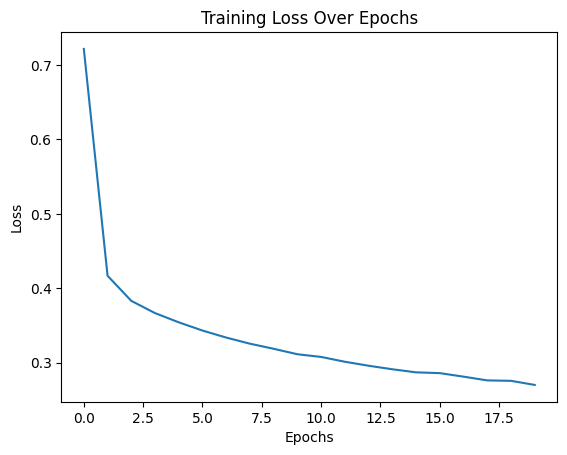

Accuracy on test data: 0.8183415881131171


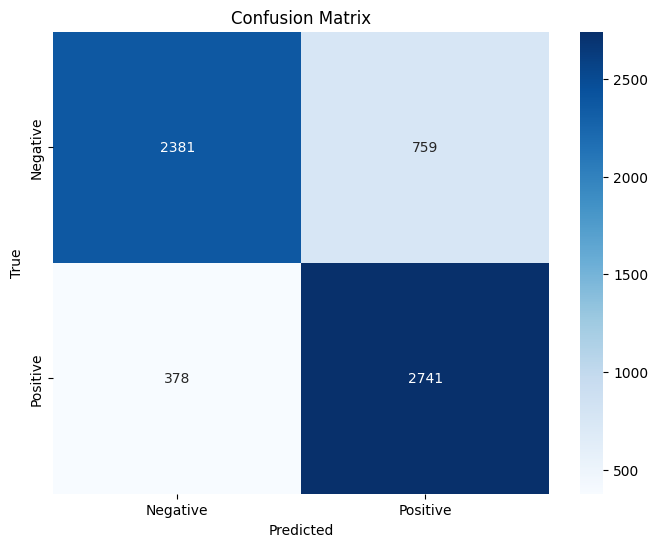

In [ ]:
# Training the model

from sklearn.metrics import accuracy_score, confusion_matrix
# Lists to store training loss for plotting
losses = []

num_epochs = 2000  # Flexible and Adjustable

# Training loop
for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()

  # Forward pass
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor.view(-1, 1))

  # Backward pass and optimization
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    # Save the training loss for plotting
    losses.append(loss.item())

# Plot the training loss
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**6- Evaluate the model on the test set**

Accuracy on test data: 0.8183415881131171


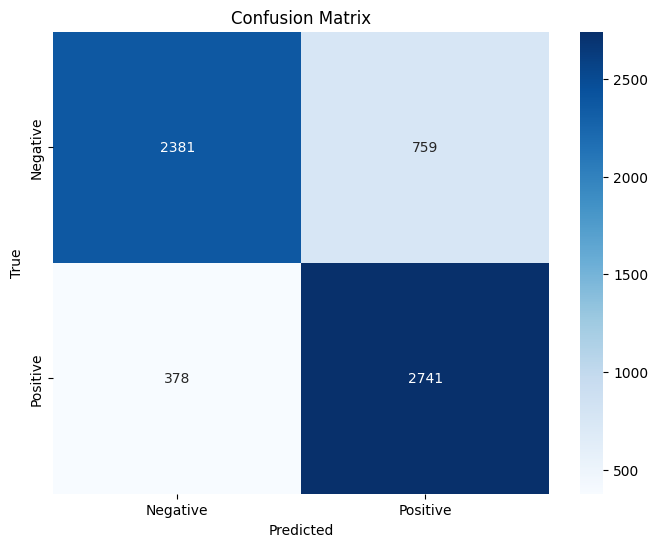

F1 Score on Test Data: 0.8150151105455703


In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    predictions = model(X_test_tensor)
    predicted_labels = (torch.sigmoid(predictions) > 0.5).float().numpy()

    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
    print(f'Accuracy on test data: {accuracy}')

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_test_tensor.numpy(), predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calculate F1 score on test set
with torch.no_grad():
    model.eval()
    test_predictions = model(X_test_tensor)
    test_predictions = (test_predictions >= 0.5).float()

    f1_test = precision_recall_fscore_support(y_test_tensor.numpy(), test_predictions.numpy(), average='binary')[2]
    print(f'F1 Score on Test Data: {f1_test}')

# Train Multi-layer Perceptron Based On Sum Word2Vec Features

**1) Convert the Numpy array data to PyTorch tensors**

In [ ]:
# Convert Numpy array sum Word2Vec features vectors to PyTorch tensors
X_train_tensor = torch.Tensor(X_sum_train_scaled)
X_test_tensor = torch.Tensor(X_sum_test_scaled)
y_train_tensor = torch.Tensor(y_train)
y_test_tensor = torch.Tensor(y_test)

print(X_train_tensor[0])

tensor([-4.7552e-01, -9.8751e-02, -1.0575e+00, -5.2865e-01, -1.7998e+00,
        -4.2242e-01, -1.8667e-01, -3.7628e-01,  8.5788e-01,  6.2552e-01,
        -4.2184e-01,  1.0939e+00,  7.1813e-01,  3.6239e-01,  9.6488e-01,
         3.5642e-01, -5.7299e-01, -9.4298e-01,  4.3102e-01,  7.8974e-01,
        -7.9421e-01, -6.9833e-01, -6.9382e-01, -7.3562e-01, -7.3453e-01,
        -6.6335e-01, -5.0130e-01,  4.6995e-01,  1.2492e+00, -8.9852e-01,
        -3.7741e-04, -7.1011e-02, -8.3721e-01,  5.8687e-02, -6.6345e-01,
        -7.8866e-01, -6.4449e-01, -4.9744e-01, -6.0881e-01,  7.7674e-01,
        -2.7901e-01, -2.9999e-01,  3.2367e-01, -3.7805e-01,  4.7301e-01,
        -6.5165e-01,  4.3486e-01,  5.9214e-01,  7.6137e-01,  5.9909e-01,
        -3.3537e-01,  9.9915e-02,  5.5418e-01, -3.7890e-01, -4.6078e-01,
         1.1476e+00, -1.0678e+00,  3.1238e-01, -5.3194e-01, -3.8089e-01,
         7.4095e-01,  4.3438e-01,  4.2830e-01, -3.0194e-01,  3.3260e-01,
        -1.8784e-01,  9.9026e-01,  6.0123e-01,  3.8

**2) Initialize MLP Model in PyTorch**

In [ ]:
import torch
import torch.nn as nn

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

**3) Initiailize the Hyper-Parameters**

In [ ]:
input_size = 200    # 200 features in Word2Vec features
hidden_size = 100    # Flexible and Adjustable
output_size = 1     # Binary classification (Happy/Sad)

**4) Define Loss Function and Optimizer**

In [ ]:
model = MLPModel(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**5) Train the Model**

Epoch [1/2000], Loss: 0.7052698135375977
Epoch [101/2000], Loss: 0.4381902813911438
Epoch [201/2000], Loss: 0.3995780050754547
Epoch [301/2000], Loss: 0.37840935587882996
Epoch [401/2000], Loss: 0.36330628395080566
Epoch [501/2000], Loss: 0.35162484645843506
Epoch [601/2000], Loss: 0.34191033244132996
Epoch [701/2000], Loss: 0.33293086290359497
Epoch [801/2000], Loss: 0.32512804865837097
Epoch [901/2000], Loss: 0.3183208107948303
Epoch [1001/2000], Loss: 0.3127894997596741
Epoch [1101/2000], Loss: 0.3080097734928131
Epoch [1201/2000], Loss: 0.30364274978637695
Epoch [1301/2000], Loss: 0.2999230921268463
Epoch [1401/2000], Loss: 0.29579904675483704
Epoch [1501/2000], Loss: 0.29195743799209595
Epoch [1601/2000], Loss: 0.28893551230430603
Epoch [1701/2000], Loss: 0.28592756390571594
Epoch [1801/2000], Loss: 0.2819978594779968
Epoch [1901/2000], Loss: 0.27972137928009033


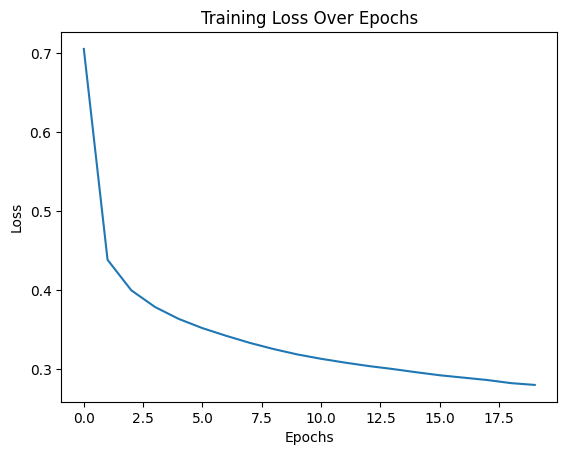

In [ ]:
# Training the model

from sklearn.metrics import accuracy_score, confusion_matrix
# Lists to store training loss for plotting
losses = []

num_epochs = 2000  # Flexible and Adjustable

# Training loop
for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()

  # Forward pass
  outputs = model(X_train_tensor)
  loss = criterion(outputs, y_train_tensor.view(-1, 1))

  # Backward pass and optimization
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    # Save the training loss for plotting
    losses.append(loss.item())

# Plot the training loss
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**6- Evaluate the model on the test set**

Accuracy on test data: 0.8151461894871386


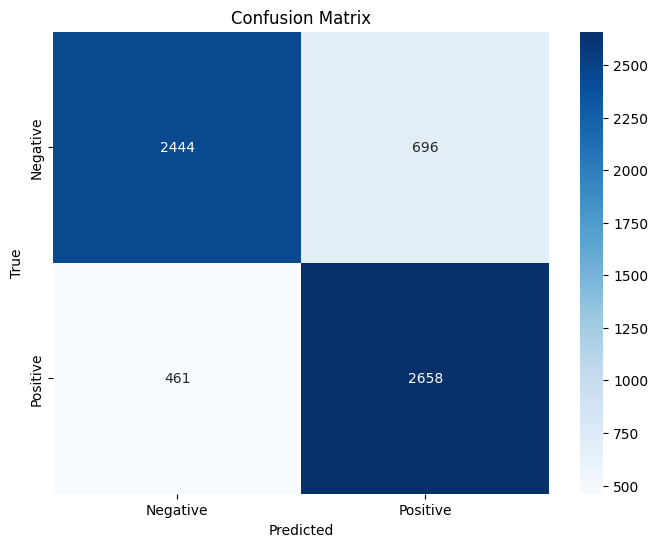

F1 Score on Test Data: 0.8000653381247959


In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    predictions = model(X_test_tensor)
    predicted_labels = (torch.sigmoid(predictions) > 0.5).float().numpy()

    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels)
    print(f'Accuracy on test data: {accuracy}')

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_test_tensor.numpy(), predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Calculate F1 score on test set
with torch.no_grad():
    model.eval()
    test_predictions = model(X_test_tensor)
    test_predictions = (test_predictions >= 0.5).float()

    f1_test = precision_recall_fscore_support(y_test_tensor.numpy(), test_predictions.numpy(), average='binary')[2]
    print(f'F1 Score on Test Data: {f1_test}')